# Performing differential expression analysis on PTM data

Here, we will take phospho data processed with Spectronaut and 
 * perform phosphosite inference and perform differential expression analysis on the phospho sites
 * take proteome data and normalize the differential expression results

## Defining input files
As with the standard differential expression analysis, we need:

* an input file from a proteomics search engine. We currently only support Spectronaut, DIA-NN will come soon
* a sample mapping file that maps each sample to a condition (e.g.  sample 'brain_replicate_1' is mapped to condition 'brain'). In the GUI, there is some functionality to help create such a file
* (optional) a results directory can be defined on where to save the data
* (optional) a list where we specify, which conditions we compare

Simple specifications on how to export the Spectronaut file for PTM analysis can be found in the [README](https://github.com/MannLabs/alphaquant/blob/master/README.md#preparing-input-files).

In [1]:
PHOSPHO_FILE = "./data/phospho/phospho_subset.tsv"
SAMPLEMAP_PHOSPHO = "./data/phospho/samplemap_phospho.tsv"
RESULTS_DIR_PHOSPHO = "./data/phospho/results_phospho"

PROTEOME_FILE = "./data/phospho/proteome_subset.tsv"
SAMPLEMAP_PROTEOME = "./data/phospho/samplemap_proteome.tsv"
RESULTS_DIR_PROTEOME = "./data/phospho/results_proteome"

CONDPAIRS_LIST = [("egf_treated", "untreated")] #this means each fc is egf_treateduntreated


Let's quickly check what the phospho tables look like:

In [2]:
import pandas as pd

phospho_df = pd.read_csv(PHOSPHO_FILE, sep="\t")
samplemap_phospho_df = pd.read_csv(SAMPLEMAP_PHOSPHO, sep="\t")
display(phospho_df.head())
#check the ptm columns
display([x for x in phospho_df.columns if "EG.PTM" in x])
#show the samplemap
display(samplemap_phospho_df.head())



/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_81071/3128896955.py:3: DtypeWarning: Columns (8,31,32,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  phospho_df = pd.read_csv(PHOSPHO_FILE, sep="\t")


,PG.ProteinGroups,R.FileName,R.Label,PG.Genes,PG.Organisms,PG.UniProtIds,PG.Quantity,PEP.NrOfMissedCleavages,PEP.PeptidePosition,PEP.StrippedSequence,...,F.FrgLossType,F.Rank,F.ExcludedFromQuantification,F.PeakArea,F.PeakHeight,F.HasChannelInterference,F.InterferenceScore,F.Log10SignalToNoise,F.Noise,F.PossibleInterference
0,Q14676,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,MDC1,Homo sapiens,Q14676,6121.10498,0,784,AIPGDQHPESPVHTEPMGIQGR,...,noloss,0,False,10883.600586,102643.0,False,0.000000,2.375846,NaN,False
1,Q14676,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,MDC1,Homo sapiens,Q14676,6121.10498,0,784,AIPGDQHPESPVHTEPMGIQGR,...,NH3,1,True,449.196930,3710.0,False,0.225726,1.297532,NaN,False
2,Q14676,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,MDC1,Homo sapiens,Q14676,6121.10498,0,784,AIPGDQHPESPVHTEPMGIQGR,...,noloss,2,False,1254.857544,10727.0,False,0.225726,1.854387,NaN,False
3,Q14676,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,MDC1,Homo sapiens,Q14676,6121.10498,0,784,AIPGDQHPESPVHTEPMGIQGR,...,noloss,3,False,964.486145,7393.0,False,0.140666,1.670164,NaN,False
4,Q14676,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,MDC1,Homo sapiens,Q14676,6121.10498,0,784,AIPGDQHPESPVHTEPMGIQGR,...,noloss,4,False,790.209412,7567.0,False,0.197118,1.339848,NaN,False


['EG.PTMPositions [Phospho (STY)]',
 'EG.PTMProbabilities [Phospho (STY)]',
 'EG.PTMSites [Phospho (STY)]',
 'EG.PTMLocalizationProbabilities',
 'EG.PTMAssayCandidateScore',
 'EG.PTMAssayProbability',
 'EG.PTMPositions [Oxidation (M)]',
 'EG.PTMPositions [Carbamidomethyl (C)]',
 'EG.PTMPositions [Acetyl (Protein N-term)]',
 'EG.PTMProbabilities [Oxidation (M)]',
 'EG.PTMProbabilities [Carbamidomethyl (C)]',
 'EG.PTMProbabilities [Acetyl (Protein N-term)]',
 'EG.PTMSites [Oxidation (M)]',
 'EG.PTMSites [Carbamidomethyl (C)]',
 'EG.PTMSites [Acetyl (Protein N-term)]']

,sample,condition
0,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,egf_treated
1,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,egf_treated
2,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,egf_treated
3,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,untreated
4,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,untreated


importantly, here are site probability columns for different types of variable modifications including phospho

## Running AlphaQuant on phospho

Calling AlphaQuant on ptm data, we additionally have to specify the modification we are interested in. In our case it is `[Phospho (STY)]` as listed in the headers above

In [3]:
import alphaquant.run_pipeline as aq_pipeline

aq_pipeline.run_pipeline(input_file=PHOSPHO_FILE, samplemap_file=SAMPLEMAP_PHOSPHO, results_dir=RESULTS_DIR_PHOSPHO, 
                        condpairs_list=CONDPAIRS_LIST, perform_ptm_mapping=True,modification_type="[Phospho (STY)]",organism="human")

2024-03-15 16:37:00,081 - alphaquant.run_pipeline - INFO - Starting AlphaQuant
2024-03-15 16:37:00,548 - alphaquant.ptm.ptmsite_mapping - INFO - filtered PTM peptides from 3219 to 2845
/Users/constantin/workspace/alphaquant/alphaquant/ptm/ptmsite_mapping.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df.loc[:,"REFPROT"] = get_idmap_column(input_df[headers_dict.get("proteins")],swissprot_ids)
/Users/constantin/workspace/alphaquant/alphaquant/ptm/ptmsite_mapping.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

using input type spectronaut_ptm_fragion_isotopes


,F.PeakArea,F.FrgLossType,PEP.StrippedSequence,F.FrgIon,ptm_mapped_modseq,F.Charge,protein,FG.Charge,R.Label,SEQ,MOD,CHARGE,FRGION
0,10883.600586,noloss,AIPGDQHPESPVHTEPMGIQGR,y20,_AIPGDQHPESPVHTEPMGIQGR_['S793'],3,MDC1_Q14676_['S793'],3,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPMGIQGR_['S793'],CHARGE_3,FRGION_y20_noloss_3
1,449.196930,NH3,AIPGDQHPESPVHTEPMGIQGR,y20,_AIPGDQHPESPVHTEPMGIQGR_['S793'],3,MDC1_Q14676_['S793'],3,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPMGIQGR_['S793'],CHARGE_3,FRGION_y20_NH3_3
2,1254.857544,noloss,AIPGDQHPESPVHTEPMGIQGR,y20,_AIPGDQHPESPVHTEPMGIQGR_['S793'],2,MDC1_Q14676_['S793'],3,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPMGIQGR_['S793'],CHARGE_3,FRGION_y20_noloss_2
3,964.486145,noloss,AIPGDQHPESPVHTEPMGIQGR,y7,_AIPGDQHPESPVHTEPMGIQGR_['S793'],1,MDC1_Q14676_['S793'],3,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPMGIQGR_['S793'],CHARGE_3,FRGION_y7_noloss_1
4,790.209412,noloss,AIPGDQHPESPVHTEPMGIQGR,y15,_AIPGDQHPESPVHTEPMGIQGR_['S793'],2,MDC1_Q14676_['S793'],3,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPMGIQGR_['S793'],CHARGE_3,FRGION_y15_noloss_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52930,71.832108,noloss,DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,y15,_DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl (C)...,2,EGFR_P00533_['Y1138'],5,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,SEQ_DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,MOD__DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl...,CHARGE_5,FRGION_y15_noloss_2
52931,41.210613,noloss,DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,y9,_DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl (C)...,1,EGFR_P00533_['Y1138'],5,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,SEQ_DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,MOD__DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl...,CHARGE_5,FRGION_y9_noloss_1
52932,6.592066,noloss,DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,y12,_DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl (C)...,1,EGFR_P00533_['Y1138'],5,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,SEQ_DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,MOD__DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl...,CHARGE_5,FRGION_y12_noloss_1
52933,9.868970,H2O,DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,b11,_DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl (C)...,2,EGFR_P00533_['Y1138'],5,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,SEQ_DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,MOD__DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl...,CHARGE_5,FRGION_b11_H2O_2


,PEP.StrippedSequence,ptm_mapped_modseq,protein,FG.Charge,R.Label,FG.MS1IsotopeIntensities (Measured)_idxs,FG.MS1IsotopeIntensities (Measured),SEQ,MOD,CHARGE,MS1ISOTOPES
0,AIPGDQHPESPVHTEPMGIQGR,_AIPGDQHPESPVHTEPMGIQGR_['S793'],MDC1_Q14676_['S793'],3,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,0,86800.0,SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPMGIQGR_['S793'],CHARGE_3,MS1ISOTOPES_0
0,AIPGDQHPESPVHTEPMGIQGR,_AIPGDQHPESPVHTEPMGIQGR_['S793'],MDC1_Q14676_['S793'],3,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,1,107961.0,SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPMGIQGR_['S793'],CHARGE_3,MS1ISOTOPES_1
0,AIPGDQHPESPVHTEPMGIQGR,_AIPGDQHPESPVHTEPMGIQGR_['S793'],MDC1_Q14676_['S793'],3,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,2,75610.0,SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPMGIQGR_['S793'],CHARGE_3,MS1ISOTOPES_2
0,AIPGDQHPESPVHTEPMGIQGR,_AIPGDQHPESPVHTEPMGIQGR_['S793'],MDC1_Q14676_['S793'],3,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,3,39954.0,SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPMGIQGR_['S793'],CHARGE_3,MS1ISOTOPES_3
0,AIPGDQHPESPVHTEPMGIQGR,_AIPGDQHPESPVHTEPMGIQGR_['S793'],MDC1_Q14676_['S793'],3,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,4,16299.0,SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPMGIQGR_['S793'],CHARGE_3,MS1ISOTOPES_4
...,...,...,...,...,...,...,...,...,...,...,...
52911,DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,_DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl (C)...,EGFR_P00533_['Y1138'],5,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,0,923.0,SEQ_DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,MOD__DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl...,CHARGE_5,MS1ISOTOPES_0
52911,DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,_DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl (C)...,EGFR_P00533_['Y1138'],5,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,1,1036.0,SEQ_DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,MOD__DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl...,CHARGE_5,MS1ISOTOPES_1
52911,DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,_DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl (C)...,EGFR_P00533_['Y1138'],5,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,2,1956.0,SEQ_DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,MOD__DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl...,CHARGE_5,MS1ISOTOPES_2
52911,DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,_DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl (C)...,EGFR_P00533_['Y1138'],5,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,3,1680.0,SEQ_DPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQK,MOD__DPHYQDPHSTAVGNPEYLNTVQPTC[Carbamidomethyl...,CHARGE_5,MS1ISOTOPES_3


2024-03-15 16:37:05,520 - alphaquant.diffquant.diffutils - INFO - removed pre existing /Users/constantin/workspace/alphaquant/example_nbs/data/phospho/phospho_subset_ptmsite_mapped.tsv.ml_info_table.tsv


,R.Label,PEP.StrippedSequence,FG.Charge,ptm_mapped_modseq,SEQ,MOD,CHARGE
0,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,AIPGDQHPESPVHTEPMGIQGR,3,_AIPGDQHPESPVHTEPMGIQGR_['S793'],SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPMGIQGR_['S793'],CHARGE_3
16,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,AIPGDQHPESPVHTEPMGIQGR,3,_AIPGDQHPESPVHTEPM[Oxidation (M)]GIQGR_['S793'],SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPM[Oxidation (M)]GIQGR_['S...,CHARGE_3
26,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,AIPGDQHPESPVHTEPMGIQGR,4,_AIPGDQHPESPVHTEPMGIQGR_['T797'],SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPMGIQGR_['T797'],CHARGE_4
56,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,AIPGDQHPESPVHTEPMGIQGR,4,_AIPGDQHPESPVHTEPM[Oxidation (M)]GIQGR_['S793'],SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPM[Oxidation (M)]GIQGR_['S...,CHARGE_4
81,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,AIPGDQHPESPVHTEPMGIQGR,2,_AIPGDQHPESPVHTEPM[Oxidation (M)]GIQGR_['S793'],SEQ_AIPGDQHPESPVHTEPMGIQGR,MOD__AIPGDQHPESPVHTEPM[Oxidation (M)]GIQGR_['S...,CHARGE_2
...,...,...,...,...,...,...,...
52587,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,MHLPSPTDSNFYR,3,_MHLPSPTDSNFYR_['S991'],SEQ_MHLPSPTDSNFYR,MOD__MHLPSPTDSNFYR_['S991'],CHARGE_3
52647,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,YSSDPTGALTEDSIDDTFLPVPEYINQSVPK,3,_YSSDPTGALTEDSIDDTFLPVPEYINQSVPK_['Y1092'],SEQ_YSSDPTGALTEDSIDDTFLPVPEYINQSVPK,MOD__YSSDPTGALTEDSIDDTFLPVPEYINQSVPK_['Y1092'],CHARGE_3
52709,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,YSSDPTGALTEDSIDDTFLPVPEYINQSVPK,3,_YSSDPTGALTEDSIDDTFLPVPEYINQSVPK_['Y1069'],SEQ_YSSDPTGALTEDSIDDTFLPVPEYINQSVPK,MOD__YSSDPTGALTEDSIDDTFLPVPEYINQSVPK_['Y1069'],CHARGE_3
52786,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,TPLLSSLSATSNNSTVACIDR,2,_TPLLSSLSATSNNSTVAC[Carbamidomethyl (C)]IDR_[nan],SEQ_TPLLSSLSATSNNSTVACIDR,MOD__TPLLSSLSATSNNSTVAC[Carbamidomethyl (C)]ID...,CHARGE_2


2024-03-15 16:37:05,751 - alphaquant.diffquant.condpair_analysis - INFO - start processeing condpair ('egf_treated', 'untreated')
2024-03-15 16:37:05,792 - alphaquant.norm.normalization - INFO - normalized within conditions
2024-03-15 16:37:05,799 - alphaquant.norm.normalization - INFO - median -0.04227814832683263, mode -0.1324779793151749
2024-03-15 16:37:05,800 - alphaquant.norm.normalization - INFO - using mode for shift
2024-03-15 16:37:05,800 - alphaquant.norm.normalization - INFO - shift comparison by 0.1324779793151749
2024-03-15 16:37:05,800 - alphaquant.norm.normalization - INFO - normalized between conditions
2024-03-15 16:37:06,848 - alphaquant.diffquant.condpair_analysis - INFO - checked 0 of 4201 ions
2024-03-15 16:37:07,009 - alphaquant.diffquant.condpair_analysis - INFO - checked 2000 of 4201 ions
2024-03-15 16:37:07,064 - alphaquant.diffquant.condpair_analysis - INFO - checked 4000 of 4201 ions
2024-03-15 16:37:07,878 - alphaquant.diffquant.condpair_analysis - INFO - c

### Inspecting and visualizing phospho results

Let's check out the results table located in the results directory:

In [4]:
results_file_phospho = RESULTS_DIR_PHOSPHO + "/egf_treated_VS_untreated.results.tsv"

In [5]:
import pandas as pd
df_phospho = pd.read_csv(results_file_phospho, sep="\t")
display(df_phospho.head())

,condition_pair,protein,p_value,log2fc,number_of_ions,quality_score,total_intensity,num_peptides,PEP.StrippedSequence,fdr
0,egf_treated_VS_untreated,MDC1_Q14676_['T1567'],1.134202e-02,-0.186397,70,0.285322,4210.330828,2,SSVKTPESIVPIAPELQPSTSR,1.818059e-02
1,egf_treated_VS_untreated,"GKAP1_Q5VSY0_['S23', 'S25']",1.681598e-04,0.499719,34,0.097551,301.333038,1,FALLQVDSGSGSDSEPGK,3.818628e-04
2,egf_treated_VS_untreated,PLEKHF1_Q96S99_['S227'],6.155760e-03,-0.206787,35,0.136134,3086.528556,1,QEEAEEQGAGSPGQPAHLAR,1.032274e-02
3,egf_treated_VS_untreated,EGFR_P00533_[nan],9.658940e-14,-0.374556,122,0.485051,3417.923736,1,ALMDEEDMDDVVDADEYLIPQQGFFSSPSTSR,6.580153e-13
4,egf_treated_VS_untreated,NBR1_Q14596_[nan],6.747529e-01,0.122811,64,0.243419,1140.975990,3,VPHNTPVDVTPCMSPLPHDSPLIEK,7.210595e-01


#### Volcano plot

(<Figure size 288x288 with 1 Axes>,
 <AxesSubplot:title={'center':'27 up, 6 down of 109'}, xlabel='log2(FC)', ylabel='-log10(fdr)'>)

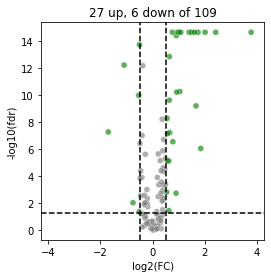

In [6]:
import alphaquant.plotting.pairwise as aq_plotting_pairwise

aq_plotting_pairwise.volcano_plot(df_phospho)

#### Normalization check

In [7]:
normalized_df = pd.read_csv(RESULTS_DIR_PHOSPHO + "/egf_treated_VS_untreated.normed.tsv", sep='\t')
samplemap_df = pd.read_csv(SAMPLEMAP_PHOSPHO, sep='\t')

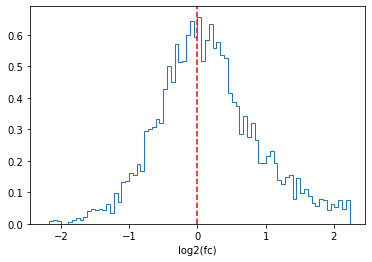

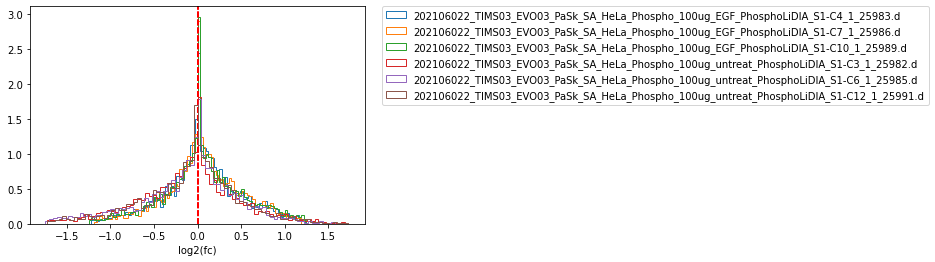

In [8]:
aq_plotting_pairwise.plot_normalization_overview(normalized_df, samplemap_df)


## Run AlphaQuant on proteome data

2024-03-15 16:37:14,033 - alphaquant.run_pipeline - INFO - Starting AlphaQuant


using input type spectronaut_fragion_isotopes


,EG.ModifiedSequence,F.PeakArea,F.FrgLossType,PEP.StrippedSequence,F.FrgIon,F.Charge,protein,FG.Charge,R.Label,SEQ,MOD,CHARGE,FRGION
0,_GPLTVEETPR_,31057.744141,noloss,GPLTVEETPR,y7,1,MDC1,2,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,SEQ_GPLTVEETPR,MOD__GPLTVEETPR_,CHARGE_2,FRGION_y7_noloss_1
1,_GPLTVEETPR_,19171.539062,noloss,GPLTVEETPR,y6,1,MDC1,2,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,SEQ_GPLTVEETPR,MOD__GPLTVEETPR_,CHARGE_2,FRGION_y6_noloss_1
2,_GPLTVEETPR_,9611.023438,noloss,GPLTVEETPR,y8,1,MDC1,2,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,SEQ_GPLTVEETPR,MOD__GPLTVEETPR_,CHARGE_2,FRGION_y8_noloss_1
3,_GPLTVEETPR_,19900.537109,noloss,GPLTVEETPR,y5,1,MDC1,2,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,SEQ_GPLTVEETPR,MOD__GPLTVEETPR_,CHARGE_2,FRGION_y5_noloss_1
4,_GPLTVEETPR_,27730.000000,noloss,GPLTVEETPR,b3,1,MDC1,2,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,SEQ_GPLTVEETPR,MOD__GPLTVEETPR_,CHARGE_2,FRGION_b3_noloss_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34704,_EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,2088.368896,noloss,EILDEAYVMASVDNPHVCR,y5,1,EGFR,3,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,SEQ_EILDEAYVMASVDNPHVCR,MOD__EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,CHARGE_3,FRGION_y5_noloss_1
34705,_EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,959.741028,noloss,EILDEAYVMASVDNPHVCR,y11,1,EGFR,3,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,SEQ_EILDEAYVMASVDNPHVCR,MOD__EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,CHARGE_3,FRGION_y11_noloss_1
34706,_EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,410.152100,noloss,EILDEAYVMASVDNPHVCR,y6,1,EGFR,3,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,SEQ_EILDEAYVMASVDNPHVCR,MOD__EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,CHARGE_3,FRGION_y6_noloss_1
34707,_EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,104.597099,noloss,EILDEAYVMASVDNPHVCR,y8,1,EGFR,3,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,SEQ_EILDEAYVMASVDNPHVCR,MOD__EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,CHARGE_3,FRGION_y8_noloss_1


,EG.ModifiedSequence,PEP.StrippedSequence,protein,FG.Charge,R.Label,FG.MS1IsotopeIntensities (Measured)_idxs,FG.MS1IsotopeIntensities (Measured),SEQ,MOD,CHARGE,MS1ISOTOPES
0,_GPLTVEETPR_,GPLTVEETPR,MDC1,2,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,0,1695373.0,SEQ_GPLTVEETPR,MOD__GPLTVEETPR_,CHARGE_2,MS1ISOTOPES_0
0,_GPLTVEETPR_,GPLTVEETPR,MDC1,2,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,1,694754.2,SEQ_GPLTVEETPR,MOD__GPLTVEETPR_,CHARGE_2,MS1ISOTOPES_1
0,_GPLTVEETPR_,GPLTVEETPR,MDC1,2,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,2,537874.6,SEQ_GPLTVEETPR,MOD__GPLTVEETPR_,CHARGE_2,MS1ISOTOPES_2
6,_VLFTGVVDAR_,VLFTGVVDAR,MDC1,2,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,0,1276688.9,SEQ_VLFTGVVDAR,MOD__VLFTGVVDAR_,CHARGE_2,MS1ISOTOPES_0
6,_VLFTGVVDAR_,VLFTGVVDAR,MDC1,2,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,1,813400.9,SEQ_VLFTGVVDAR,MOD__VLFTGVVDAR_,CHARGE_2,MS1ISOTOPES_1
...,...,...,...,...,...,...,...,...,...,...,...
34703,_EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,EILDEAYVMASVDNPHVCR,EGFR,3,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,1,279992.4,SEQ_EILDEAYVMASVDNPHVCR,MOD__EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,CHARGE_3,MS1ISOTOPES_1
34703,_EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,EILDEAYVMASVDNPHVCR,EGFR,3,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,2,253061.2,SEQ_EILDEAYVMASVDNPHVCR,MOD__EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,CHARGE_3,MS1ISOTOPES_2
34703,_EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,EILDEAYVMASVDNPHVCR,EGFR,3,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,3,156860.4,SEQ_EILDEAYVMASVDNPHVCR,MOD__EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,CHARGE_3,MS1ISOTOPES_3
34712,_DTC[Carbamidomethyl (C)]PPLMLYNPTTYQMDVNPEGK_,DTCPPLMLYNPTTYQMDVNPEGK,EGFR,3,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,1,62658.9,SEQ_DTCPPLMLYNPTTYQMDVNPEGK,MOD__DTC[Carbamidomethyl (C)]PPLMLYNPTTYQMDVNP...,CHARGE_3,MS1ISOTOPES_1


2024-03-15 16:37:15,170 - alphaquant.diffquant.diffutils - INFO - removed pre existing /Users/constantin/workspace/alphaquant/example_nbs/data/phospho/proteome_subset.tsv.ml_info_table.tsv


,R.Label,PEP.StrippedSequence,EG.PeakWidth (iRT),EG.IsDecoy,EG.ModifiedSequence,EG.PEP,EG.Pvalue,EG.Qvalue,EG.Svalue,EG.FWHM (iRT),...,FG.Reference,FG.MS1RawQuantity,FG.MS2RawQuantity,FG.HasPossibleInterference (MS1),FG.HasPossibleInterference (MS2),FG.Quantity,FG.ReporterIons,SEQ,MOD,CHARGE
0,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,GPLTVEETPR,0.362724,False,_GPLTVEETPR_,0.000032,8.148244e-06,3.562377e-06,0.315552,0.276253,...,False,345070.656250,70129.820312,True,True,54499.324219,NaN,SEQ_GPLTVEETPR,MOD__GPLTVEETPR_,CHARGE_2
6,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,VLFTGVVDAR,0.350497,False,_VLFTGVVDAR_,0.000003,3.027607e-07,2.024975e-07,0.206266,0.196353,...,False,239111.765625,61322.074219,True,True,45869.105469,NaN,SEQ_VLFTGVVDAR,MOD__VLFTGVVDAR_,CHARGE_2
12,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,LDVSLPFVSR,0.496075,False,_LDVSLPFVSR_,0.000388,1.580871e-04,4.279705e-05,0.509579,0.245439,...,False,379806.531250,65929.234375,True,True,39182.449219,NaN,SEQ_LDVSLPFVSR,MOD__LDVSLPFVSR_,CHARGE_2
18,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,FTPELQPK,0.381712,False,_FTPELQPK_,0.000654,4.417026e-04,9.790618e-05,0.622329,0.312390,...,False,285085.250000,58044.039062,True,True,45437.378906,NaN,SEQ_FTPELQPK,MOD__FTPELQPK_,CHARGE_2
24,20230330_EXPL0_MCT_SA_aQ2_HeLa_EGF_120min_100n...,EGAQVPTGR,0.450930,False,_EGAQVPTGR_,0.000287,1.100646e-04,3.214802e-05,0.472310,0.203866,...,False,160771.515625,49025.511719,True,True,39006.375000,NaN,SEQ_EGAQVPTGR,MOD__EGAQVPTGR_,CHARGE_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34690,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,EYHAEGGK,0.457480,False,_EYHAEGGK_,0.014061,5.577442e-03,1.252145e-03,0.783692,0.517760,...,False,24957.261719,2764.058105,True,True,2695.590088,NaN,SEQ_EYHAEGGK,MOD__EYHAEGGK_,CHARGE_2
34696,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,SPSDCCHNQCAAGCTGPR,0.163791,False,_SPSDC[Carbamidomethyl (C)]C[Carbamidomethyl (...,0.000093,2.799248e-05,2.072937e-05,0.237879,0.145748,...,False,22798.320312,1046.360107,True,True,913.622803,NaN,SEQ_SPSDCCHNQCAAGCTGPR,MOD__SPSDC[Carbamidomethyl (C)]C[Carbamidometh...,CHARGE_3
34702,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,EILDEAYVMASVDNPHVCR,0.357067,False,_EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,0.000072,1.948467e-05,1.633920e-05,0.210070,0.254061,...,False,74276.328125,1370.109375,True,True,1056.526489,NaN,SEQ_EILDEAYVMASVDNPHVCR,MOD__EILDEAYVMASVDNPHVC[Carbamidomethyl (C)]R_,CHARGE_3
34708,20230330_EXPL0_MCT_SA_aQ2_HeLa_unt_120min_100n...,DTCPPLMLYNPTTYQMDVNPEGK,0.186916,False,_DTC[Carbamidomethyl (C)]PPLMLYNPTTYQMDVNPEGK_,0.011684,4.799886e-03,1.092475e-03,0.773133,0.123649,...,False,5363.799316,453.862854,True,True,319.954163,NaN,SEQ_DTCPPLMLYNPTTYQMDVNPEGK,MOD__DTC[Carbamidomethyl (C)]PPLMLYNPTTYQMDVNP...,CHARGE_3


2024-03-15 16:37:15,527 - alphaquant.diffquant.condpair_analysis - INFO - start processeing condpair ('egf_treated', 'untreated')
2024-03-15 16:37:15,556 - alphaquant.norm.normalization - INFO - normalized within conditions
2024-03-15 16:37:15,562 - alphaquant.norm.normalization - INFO - median 0.3736080582187675, mode 0.49142721072130446
2024-03-15 16:37:15,563 - alphaquant.norm.normalization - INFO - using mode for shift
2024-03-15 16:37:15,563 - alphaquant.norm.normalization - INFO - shift comparison by -0.49142721072130446
2024-03-15 16:37:15,563 - alphaquant.norm.normalization - INFO - normalized between conditions
2024-03-15 16:37:15,943 - alphaquant.diffquant.condpair_analysis - INFO - checked 0 of 4178 ions
2024-03-15 16:37:16,224 - alphaquant.diffquant.condpair_analysis - INFO - checked 2000 of 4178 ions
2024-03-15 16:37:16,316 - alphaquant.diffquant.condpair_analysis - INFO - checked 4000 of 4178 ions
2024-03-15 16:37:18,103 - alphaquant.diffquant.condpair_analysis - INFO - c

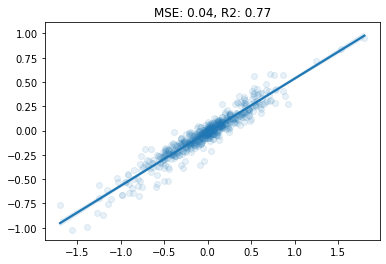

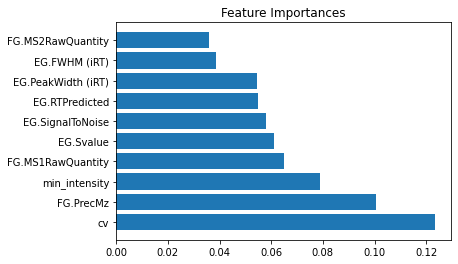

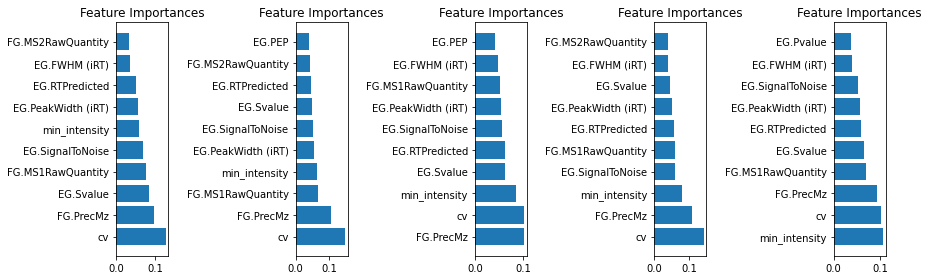

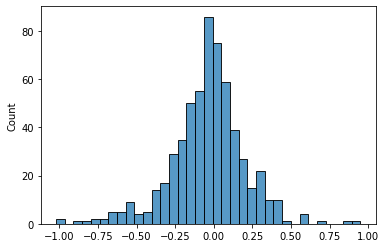

2024-03-15 16:37:22,189 - alphaquant.diffquant.condpair_analysis - INFO - ML based quality score above quality threshold and added to the nodes.
2024-03-15 16:37:22,524 - alphaquant.diffquant.condpair_analysis - INFO - condition pair ('egf_treated', 'untreated') finished!


In [9]:
import alphaquant.run_pipeline as aq_pipeline

aq_pipeline.run_pipeline(input_file=PROTEOME_FILE, samplemap_file=SAMPLEMAP_PROTEOME, 
                         results_dir=RESULTS_DIR_PROTEOME, condpairs_list=CONDPAIRS_LIST)

### Volcano plot

In [10]:
results_file_proteome = RESULTS_DIR_PROTEOME + "/egf_treated_VS_untreated.results.tsv"

(<Figure size 288x288 with 1 Axes>,
 <AxesSubplot:title={'center':'0 up, 0 down of 30'}, xlabel='log2(FC)', ylabel='-log10(fdr)'>)

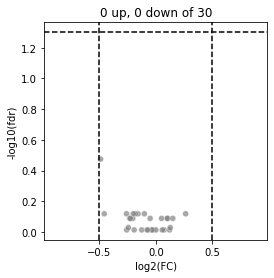

In [11]:
import alphaquant.plotting.pairwise as aq_plotting_pairwise

df_proteome = pd.read_csv(results_file_proteome, sep="\t")
aq_plotting_pairwise.volcano_plot(df_proteome)

There is very little regulation on the protein level.

### Normalization plot

In [12]:
%reload_ext autoreload
%autoreload 2

## Combining phospho and proteome data by proteome-normalization

The following command writes out the proteome normed files into a new results directory with the ending "_protnormed"

In [13]:
import alphaquant.ptm.protein_ptm_normalization as aq_ptm_normalization




aq_ptm_normalization.PTMResultsNormalizer(results_dir_ptm=RESULTS_DIR_PHOSPHO, 
                                          results_dir_proteome=RESULTS_DIR_PROTEOME, organism="human")

2024-03-15 16:37:23,916 - alphaquant.ptm.protein_ptm_normalization - INFO - wrote proteome normalized tables to: ./data/phospho/results_phospho_protnormed


### Volcano plot

In [14]:
results_file_protnormed = f"{RESULTS_DIR_PHOSPHO}_protnormed/egf_treated_VS_untreated.results.tsv"

(<Figure size 288x288 with 1 Axes>,
 <AxesSubplot:title={'center':'33 up, 6 down of 103'}, xlabel='log2(FC)', ylabel='-log10(fdr)'>)

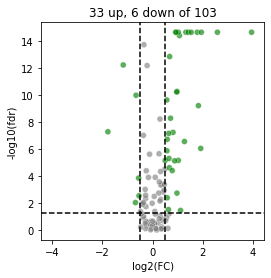

In [15]:
import alphaquant.plotting.pairwise as aq_plotting_pairwise

df_protnormed = pd.read_csv(results_file_protnormed, sep="\t")
aq_plotting_pairwise.volcano_plot(df_protnormed)

As expected, there is little qualitative change to this plot, because the protein regulation is low. Let's investigate this a bit futher:

Text(0, 0.5, 'log2fc_proteome')

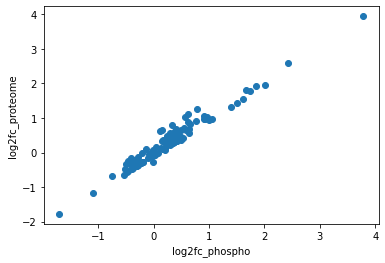

In [16]:
import matplotlib.pyplot as plt
merged_df = df_phospho.merge(df_protnormed, on="protein", how="inner", suffixes=("_phospho", "_proteome"))
plt.scatter(merged_df["log2fc_phospho"], merged_df["log2fc_proteome"])
plt.xlabel("log2fc_phospho")
plt.ylabel("log2fc_proteome")

Indeed we see few changes per phospo site, but some difference due to some protein fold changes, as expected.